In [1]:
# Open training, testing data from CSV files
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_train = [r for r in reader]
csv_file.close()
with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_test = [r for r in reader]
csv_file.close()

# Only use compounds with experimental RON/MON data; calculate sensitivity
smiles_train = []
mon_train = []
ron_train = []
for comp in rows_train:
    if comp['Meas MON'] != 'n.a.' and comp['Meas RON'] != 'n.a.':
        smiles_train.append(comp[' SMILES'])
        mon_train.append([float(comp['Meas MON'])])
        ron_train.append([float(comp['Meas RON'])])
os_train = [[ron_train[i][0] - mon_train[i][0]] for i in range(len(smiles_train))]
smiles_test = []
mon_test = []
ron_test = []
for comp in rows_test:
    if comp['Meas MON'] != 'n.a.' and comp['Meas RON'] != 'n.a.':
        smiles_test.append(comp[' SMILES'])
        mon_test.append([float(comp['Meas MON'])])
        ron_test.append([float(comp['Meas RON'])])
os_test = [[ron_test[i][0] - mon_test[i][0]] for i in range(len(smiles_test))]

print(len(smiles_train), len(mon_train), len(ron_train), len(os_train))
print(len(smiles_test), len(mon_test), len(ron_test), len(os_test))

265 265 265 265
51 51 51 51


In [2]:
# Generate QSPR descriptors for training, testing sets
from ecnet.datasets import QSPRDataset

dataset_mon_train = QSPRDataset(smiles_train, mon_train, backend='alvadesc')
dataset_ron_train = QSPRDataset(smiles_train, ron_train, backend='alvadesc')
dataset_os_train = QSPRDataset(smiles_train, os_train, backend='alvadesc')

dataset_mon_test = QSPRDataset(smiles_test, mon_test, backend='alvadesc')
dataset_ron_test = QSPRDataset(smiles_test, ron_test, backend='alvadesc')
dataset_os_test = QSPRDataset(smiles_test, os_test, backend='alvadesc')

In [3]:
# Normalize all input data
from sklearn.preprocessing import MinMaxScaler
import torch

scalar_mon = MinMaxScaler()
scalar_mon.fit(dataset_mon_train.desc_vals)
dataset_mon_train.desc_vals = torch.tensor(scalar_mon.transform(dataset_mon_train.desc_vals)).float()
dataset_mon_test.desc_vals = torch.tensor(scalar_mon.transform(dataset_mon_test.desc_vals)).float()

scalar_ron = MinMaxScaler()
scalar_ron.fit(dataset_ron_train.desc_vals)
dataset_ron_train.desc_vals = torch.tensor(scalar_ron.transform(dataset_ron_train.desc_vals)).float()
dataset_ron_test.desc_vals = torch.tensor(scalar_ron.transform(dataset_ron_test.desc_vals)).float()

scalar_os = MinMaxScaler()
scalar_os.fit(dataset_os_train.desc_vals)
dataset_os_train.desc_vals = torch.tensor(scalar_os.transform(dataset_os_train.desc_vals)).float()
dataset_os_test.desc_vals = torch.tensor(scalar_os.transform(dataset_os_test.desc_vals)).float()

In [4]:
# Training
from copy import deepcopy
from ecnet import ECNet
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA

train_mae = []
train_r2 = []
test_mae = []
test_r2 = []

# Evaluate every 8 input additions
for n_inp in range(0, dataset_mon_train.desc_vals.shape[0] - 1, 8):
    print(f'Inp: {n_inp + 1}/{dataset_mon_train.desc_vals.shape[0]}')

    _ds_train = deepcopy(dataset_mon_train)
    _ds_test = deepcopy(dataset_mon_test)
    pca = PCA(n_components=n_inp + 1, svd_solver='full')
    pca.fit(_ds_train.desc_vals.detach().numpy())
    _ds_train.desc_vals = torch.from_numpy(
        pca.transform(_ds_train.desc_vals.detach().numpy())
    )
    _ds_test.desc_vals = torch.from_numpy(
        pca.transform(_ds_test.desc_vals.detach().numpy())
    )

    _tr_mae = []
    _tr_r2 = []
    _te_mae = []
    _te_r2 = []

    # 10 ANNs at every input addition to measure variance
    for _ in range(10):

        _model = ECNet(_ds_train.desc_vals.shape[1], _ds_train.target_vals.shape[1], 128, 1)
        _model.fit(dataset=_ds_train, valid_size=0.2, patience=64, epochs=512, random_state=None, lr=0.001, lr_decay=1e-8, batch_size=32)
        y_hat_train = _model(_ds_train.desc_vals).detach().numpy()
        y_hat_test = _model(_ds_test.desc_vals).detach().numpy()
        y_train = _ds_train.target_vals.detach().numpy()
        y_test = _ds_test.target_vals.detach().numpy()
        _tr_mae.append(mean_absolute_error(y_hat_train, y_train))
        _tr_r2.append(r2_score(y_hat_train, y_train))
        _te_mae.append(mean_absolute_error(y_hat_test, y_test))
        _te_r2.append(r2_score(y_hat_test, y_test))

    train_mae.append(_tr_mae)
    train_r2.append(_tr_r2)
    test_mae.append(_te_mae)
    test_r2.append(_te_r2)

Inp: 1/265
Inp: 9/265
Inp: 17/265
Inp: 25/265
Inp: 33/265
Inp: 41/265
Inp: 49/265
Inp: 57/265
Inp: 65/265
Inp: 73/265
Inp: 81/265
Inp: 89/265
Inp: 97/265
Inp: 105/265
Inp: 113/265
Inp: 121/265
Inp: 129/265
Inp: 137/265
Inp: 145/265
Inp: 153/265
Inp: 161/265
Inp: 169/265
Inp: 177/265
Inp: 185/265
Inp: 193/265
Inp: 201/265
Inp: 209/265
Inp: 217/265
Inp: 225/265
Inp: 233/265
Inp: 241/265
Inp: 249/265
Inp: 257/265


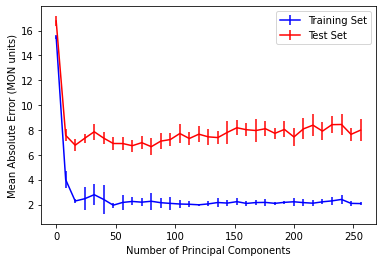

In [6]:
import numpy as np
from matplotlib import pyplot as plt

tr_mae_std = [np.std(mae) for mae in train_mae]
tr_r2_std = [np.std(r2) for r2 in train_r2]
te_mae_std = [np.std(mae) for mae in test_mae]
te_r2_std = [np.std(r2) for r2 in test_r2]

n_inp = [i * 8 for i in range(len(train_mae))]

plt.clf()
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Absolute Error (MON units)')
plt.errorbar(n_inp, [np.mean(mae) for mae in train_mae], yerr=tr_mae_std, color='blue', label='Training Set')
plt.errorbar(n_inp, [np.mean(mae) for mae in test_mae], yerr=te_mae_std, color='red', label='Test Set')
plt.legend(loc='upper right')
plt.show()

In [7]:
print(min([np.mean(mae) for mae in test_mae]))
print(np.mean(te_mae_std))

6.6528497
0.62512463
